In [1]:
import photutils
import stpsf
import matplotlib.pylab as plt
from astropy.nddata import Cutout2D
from photutils.detection import IRAFStarFinder


In [2]:
import numpy as np
from astropy.io import fits
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, ApertureStats

file = '../ESO484/NIRCam/finals/F430M_FULL_stage3.fits'

with fits.open(file) as psf:
    data = psf['SCI'].data
    weight_map = psf['WHT'].data # Load weights instead of DQ

mask = (weight_map == 0)

bg_coordinates = [
    (847, 4363),  # Region 1
    (3727, 589), # Region 2
    (313, 1075), # Region 3
    (4531, 709) # Region 4
]

# 4. Define the radius 'n' (in pixels)
radius = 50 

apertures = CircularAperture(bg_coordinates, r=radius)

sigma_clip = SigmaClip(sigma=3.0)
phot_stats = ApertureStats(data, apertures, mask=mask, sigma_clip=sigma_clip)

four_medians = phot_stats.median 
print(f"Medians of the 4 regions: {four_medians}")

final_bg_value = np.nanmean(four_medians)

print(f"Final Background Value (Mean of Medians): {final_bg_value}")

data_subtracted = data - final_bg_value

# 5. Create a "Safe" version for Log Plotting
# We create a copy so we don't destroy the scientific integrity of the original array
data_safe = data_subtracted.copy()

# A. Find all values that are strictly POSITIVE
positive_mask = (data_safe > 0)

if np.any(positive_mask):
    # B. Find the absolute minimum among the positive values
    min_positive_value = np.min(data_safe[positive_mask])
    print(f"Lowest valid positive value found: {min_positive_value}")
    
    # C. Replace all Non-Positive values (<= 0) with that minimum
    # This "floors" the data so log10 works everywhere
    data_safe[~positive_mask] = min_positive_value

else:
    # Fallback: If literally everything is negative (very rare), set a small epsilon
    print("Warning: No positive values found. Setting floor to 1e-9")
    data_safe[:] = 1e-9

Medians of the 4 regions: [       nan        nan 0.16529399        nan]
Final Background Value (Mean of Medians): 0.16529399156570435
Lowest valid positive value found: 1.4901161193847656e-08


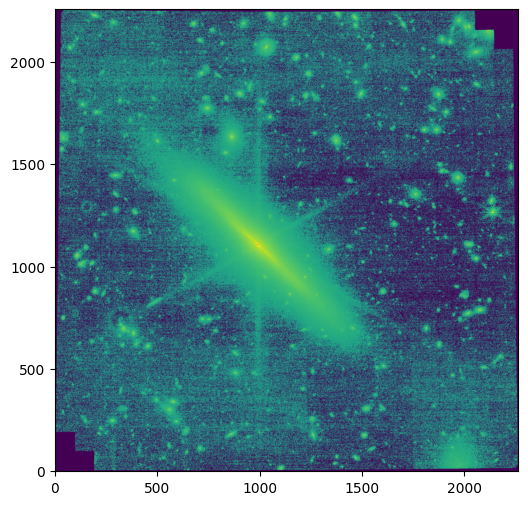

In [3]:
import matplotlib.colors as colors

plt.figure(figsize = (6,6))
plt.imshow(data_safe, norm=colors.LogNorm(), origin = 'lower', cmap='viridis')

Text(0.5, 1.0, 'Cutout around a galaxy merger and a star')

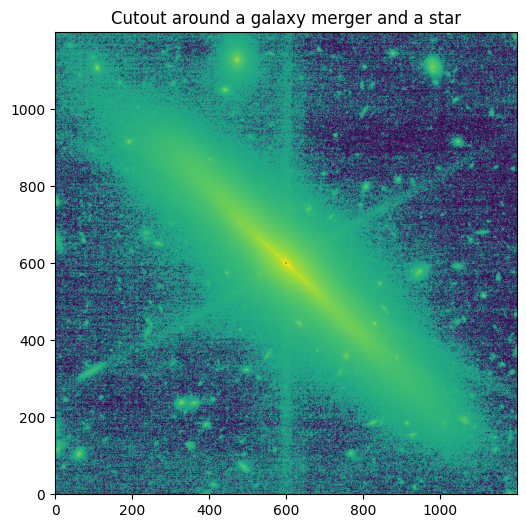

In [4]:
position = (991, 1106)    # approximate location. This will be improved below.
size_pixels = 1200         # size of subarray to use

data_source = Cutout2D(data_safe, position, size_pixels).data
plt.figure(figsize = (6,6))
plt.imshow(data_source, norm = colors.LogNorm(), origin = 'lower', cmap='viridis')
plt.title("Cutout around a galaxy merger and a star")

In [22]:
starfind = IRAFStarFinder(fwhm=3.0, threshold=100.*final_bg_value)
sources = starfind(data_source)[2]

In [23]:
sources

id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
3,599.6563590470364,599.6332498272048,1.733698107843915,0.577899369281305,0.14247421249236125,120.08360708916015,10,168.58552599077422,693.2405977373321,-7.10220997013436


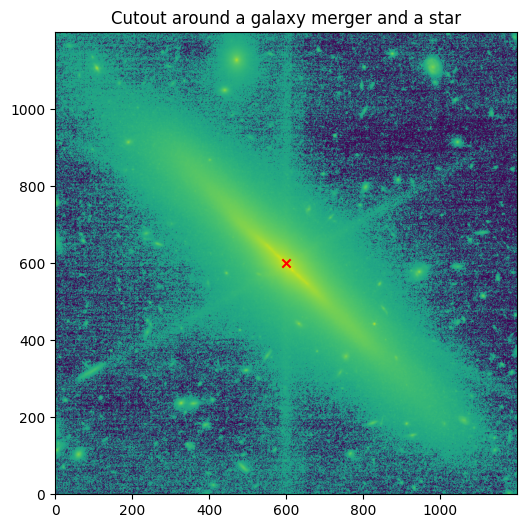

In [24]:
plt.figure(figsize = (6,6))
plt.imshow(data_source, norm = colors.LogNorm(), origin = 'lower', cmap='viridis')
plt.title("Cutout around a galaxy merger and a star")
plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red', marker='x')

In [25]:
positions_original = Cutout2D(data_safe, position, size_pixels).to_original_position((sources['xcentroid'],sources['ycentroid']))

In [26]:
positions_original

(np.float64(991.6563590470364), np.float64(1106.633249827205))

Text(0.5, 1.0, 'Cutout centered on the star')

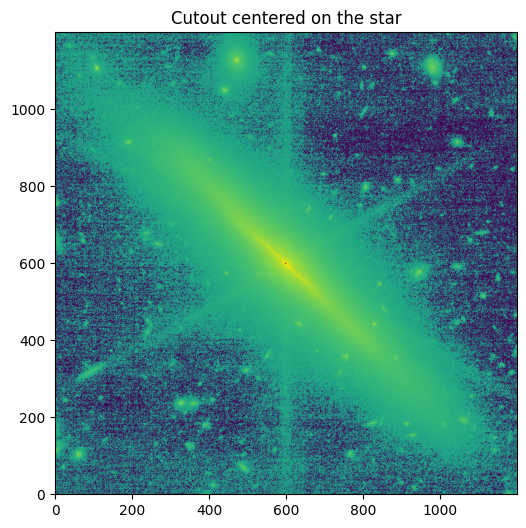

In [27]:
position = (positions_original[0], positions_original[1])
size = 1200
data_source = Cutout2D(data_safe, position, size_pixels).data

plt.figure(figsize = (6,6))
plt.imshow(data_source, norm = colors.LogNorm(), origin = 'lower', cmap='viridis')
plt.title("Cutout centered on the star")

In [28]:
position

(np.float64(991.6563590470364), np.float64(1106.633249827205))

In [29]:
inst = stpsf.setup_sim_to_match_file(file)
inst.detector_position = position

single_stpsf_nrc = inst.calc_psf(fov_pixels=size_pixels)

Setting up sim to match ../ESO484/NIRCam/finals/F430M_FULL_stage3.fits

MAST OPD query around UTC: 2024-12-06T16:21:54.532
                        MJD: 60650.681881157405

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2024120603-NRCA1_FP6-1.fits
	Date (MJD):	 60650.0379
	Delta time:	 -0.6440 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2024121001-NRCA1_FP6-1.fits
	Date (MJD):	 60653.2681
	Delta time:	 2.5862 days
User requested choosing OPD time closest in time to 2024-12-06T16:21:54.532, which is R2024120603-NRCA1_FP6-1.fits, delta time -0.644 days
Importing and format-converting OPD from /home/joacoh/data/stpsf-data/MAST_JWST_WSS_OPDs/R2024120603-NRCA1_FP6-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA1_FP6)
Sensing inst model using apername NRCA1_FP6
Using sensing field point SI WFE model from file wss_target_phase_fp6.fits

Configured simulation instrument for:
    Instrument: NIRCam


In [30]:
stpsf_model = photutils.psf.ImagePSF(single_stpsf_nrc['DET_DIST'].data, oversampling=1)

# Fix the flux parameter so it's not fitted
stpsf_model.fixed['flux'] = True

In [76]:
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from astropy.table import Table

fit_shape = (51, 51)

# Get sources
sources = starfind(data_source)

# Create init_params with fixed flux
init_params = Table()
init_params['x'] = sources['xcentroid']
init_params['y'] = sources['ycentroid']
init_params['flux'] = 30000

psfphot = PSFPhotometry(stpsf_model, fit_shape)

# fit model PSF to background subtracted data
phot = psfphot(data_source, init_params=init_params[[2]])

In [77]:
residual =  psfphot.make_residual_image(data=data_source, psf_shape=(size_pixels, size_pixels))

Text(0.5, 1.0, 'Clean - PSFPhotometry zoom')

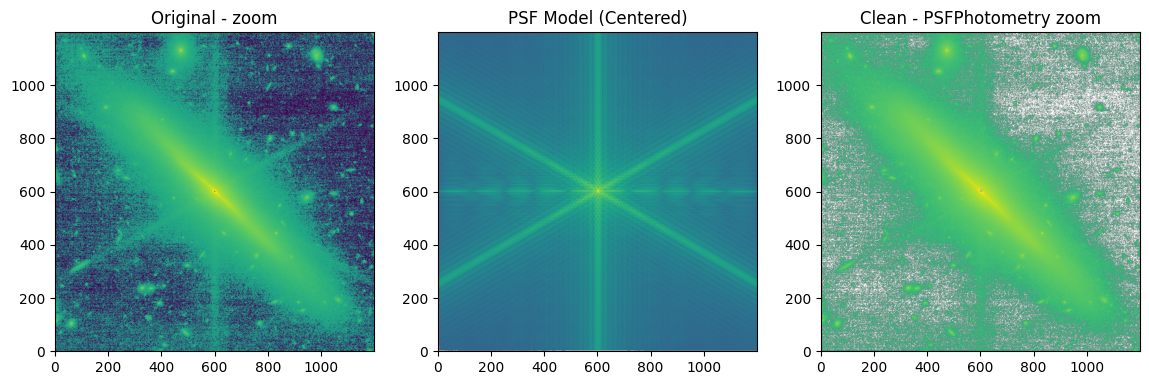

In [78]:
plt.figure(figsize = (14,16))

plt.subplot(1,3,1)
plt.imshow(data_source, norm = colors.LogNorm(), origin = 'lower', cmap='viridis')
plt.title('Original - zoom')

center = size_pixels // 2
x = np.arange(0, size_pixels, 1) - center
y = np.arange(0, size_pixels, 1) - center
xx, yy = np.meshgrid(x, y)

# Evaluate the model
model_image = psfphot.psf_model(xx, yy)

# Plot
plt.subplot(1,3,2)
plt.imshow(model_image, origin='lower', cmap='viridis', norm=colors.LogNorm())
plt.title('PSF Model (Centered)')

plt.subplot(1,3,3)
plt.imshow(residual, norm = colors.LogNorm(), origin = 'lower', cmap='viridis')
plt.title('Clean - PSFPhotometry zoom')